# Project B2 - “Environmental sound classification”

The focus of this project is estimating the effectiveness of Audio-Augmentation techinques in the context of Enviromental Sound Classification when dealing with small datasets (ESC-10).

_Federico Chiarello_ - ID: 2058163

# 1. Data Loading and Preprocessing

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import json
import time

import librosa
import librosa.display
import IPython.display
from IPython.display import Audio, display
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline
np.random.seed(42)

## Downloading Data

Downloading the __ESC-50__ dataset from the [GitHub repository](https://github.com/karolpiczak/ESC-50).

In [2]:
!git clone https://github.com/karolpiczak/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4199 (delta 40), reused 38 (delta 18), pack-reused 4136 (from 1)
Receiving objects: 100% (4199/4199), 878.79 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (2011/2011), done.


In [3]:
# Global Variables
AUDIO_PATH = 'ESC-50/audio/'
CSV_PATH = 'ESC-50/meta/esc50.csv'
SAMPLING_RATE = 44100

## Dataframe

In this subsection I performed some preliminary operations on the dataframe.

### ESC-50

Dataframe with 50 categories.

In [4]:
df_50 = pd.read_csv(CSV_PATH)
df_50

filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]

In [5]:
df_50_dict = dict(sorted(zip(df_50['target'], df_50['category'])))
print(df_50_dict)

{0: 'dog', 1: 'rooster', 2: 'pig', 3: 'cow', 4: 'frog', 5: 'cat', 6: 'hen', 7: 'insects', 8: 'sheep', 9: 'crow', 10: 'rain', 11: 'sea_waves', 12: 'crackling_fire', 13: 'crickets', 14: 'chirping_birds', 15: 'water_drops', 16: 'wind', 17: 'pouring_water', 18: 'toilet_flush', 19: 'thunderstorm', 20: 'crying_baby', 21: 'sneezing', 22: 'clapping', 23: 'breathing', 24: 'coughing', 25: 'footsteps', 26: 'laughing', 27: 'brushing_teeth', 28: 'snoring', 29: 'drinking_sipping', 30: 'door_wood_knock', 31: 'mouse_click', 32: 'keyboard_typing', 33: 'door_wood_creaks', 34: 'can_opening', 35: 'washing_machine', 36: 'vacuum_cleaner', 37: 'clock_alarm', 38: 'clock_tick', 39: 'glass_breaking', 40: 'helicopter', 41: 'chainsaw', 42: 'siren', 43: 'car_horn', 44: 'engine', 45: 'train', 46: 'church_bells', 47: 'airplane', 48: 'fireworks', 49: 'hand_saw'}


### Macro-Categories

The dataset is organized into 50 semantical classes, loosely arranged into 5 macro-categories. The following cell adds the macro-category feature to the dataframe.

The 5 __Macro-Categories__ are:
- Animals
- Natural soundscapes & water sounds
- Human, non-speech sounds
- Interior/domestic sounds
- Exterior/urban noises

In [6]:
df_50['macro_category'] = df_50['target'] // 10
df_50.head()

filename  fold  target        category  esc10  src_file take  \
0   1-100032-A-0.wav     1       0             dog   True    100032    A   
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A   
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A   
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B   
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A   

   macro_category  
0               0  
1               1  
2               3  
3               3  
4               1

In [7]:
macro_category_dict = {
    0: 'Animals',
    1: 'Natural soundscapes & water sounds',
    2: 'Human, non-speech sounds',
    3: 'Interior/domestic sounds',
    4: 'Exterior/urban noises'
}

### ESC-10

Lets create a dataframe containing only __ESC-10__ samples.

I have mapped the _target_ column to range [0, 9]. There is no correspondency between the target values in df_50 and in df_10, those would be treated as different datasets.

In [8]:
df_10 = df_50[df_50['esc10'] == True]

# Map target column to range [0,9]
unique_targets = sorted(df_10['target'].unique())
target_mapping = {old: new for new, old in enumerate(unique_targets)}
df_10.loc[:, 'target'] = df_10['target'].map(target_mapping)

df_10.head()

filename  fold  target        category  esc10  src_file take  \
0    1-100032-A-0.wav     1       0             dog   True    100032    A   
14   1-110389-A-0.wav     1       0             dog   True    110389    A   
24  1-116765-A-41.wav     1       9        chainsaw   True    116765    A   
54   1-17150-A-12.wav     1       4  crackling_fire   True     17150    A   
55  1-172649-A-40.wav     1       8      helicopter   True    172649    A   

    macro_category  
0                0  
14               0  
24               4  
54               1  
55               4

In [9]:
df_10_dict = dict(sorted(zip(df_10['target'], df_10['category'])))
print(df_10_dict)

{0: 'dog', 1: 'rooster', 2: 'rain', 3: 'sea_waves', 4: 'crackling_fire', 5: 'crying_baby', 6: 'sneezing', 7: 'clock_tick', 8: 'helicopter', 9: 'chainsaw'}


## EDA

Preliminary data analysis and visualization.

### Random Clip

Take a random clip and show informations and some visual representations.

In [10]:
df_50[df_50['filename']=='5-241846-A-15.wav']

filename  fold  target     category  esc10  src_file take  \
1908  5-241846-A-15.wav     5      15  water_drops  False    241846    A   

      macro_category  
1908               1

In [11]:
def print_waveform(array, sampling_rate):

    fig, ax = plt.subplots()
    ax.figure.set_figwidth(7)
    ax.figure.set_figheight(3)
    librosa.display.waveshow(array, sr=sampling_rate)
    ax.set(title='Waveform')
    ax.label_outer()
    plt.show()


def print_melspectrogram_and_mfccs(melspectrogram, sampling_rate, mfccs):

    fig, ax = plt.subplots(nrows=2, sharex=True)

    S_dB = librosa.power_to_db(melspectrogram, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000, ax=ax[0])
    fig.colorbar(img, ax=[ax[0]], format='%+2.0f dB')
    ax[0].set(title='Mel spectrogram')
    ax[0].label_outer()

    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
    fig.colorbar(img, ax=[ax[1]])
    ax[1].set(title='MFCC')

    plt.show()


def print_waveform_and_zcr(array, sampling_rate, zcr):

    frames = range(len(zcr[0]))
    t = librosa.frames_to_time(frames, sr=sampling_rate)

    plt.figure(figsize=(7, 6))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(array, sr=sampling_rate)
    plt.title("Waveform")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    plt.plot(t, zcr[0], label="Zero Crossing Rate", color="r")
    plt.title("Zero Crossing Rate")
    plt.ylabel("ZCR")
    plt.legend()

    plt.tight_layout()
    plt.show()


def print_delta(mfcc, mfcc_delta):

    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)

    img1 = librosa.display.specshow(mfcc, ax=ax[0], x_axis='time')
    ax[0].set(title='MFCC')
    ax[0].label_outer()
    img2 = librosa.display.specshow(mfcc_delta, ax=ax[1], x_axis='time')
    ax[1].set(title=r'MFCC-$\Delta$')
    ax[1].label_outer()
    fig.colorbar(img1, ax=[ax[0]])
    fig.colorbar(img2, ax=[ax[1]])
    plt.show()


def print_melspectrogram_deltas(melspectrogram, delta, delta2):

    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    librosa.display.specshow(melspectrogram, sr=SAMPLING_RATE, x_axis="time", y_axis="mel")
    plt.title("Mel Spectrogram (dB)")
    plt.colorbar()

    plt.subplot(3, 1, 2)
    librosa.display.specshow(delta, sr=SAMPLING_RATE, x_axis="time", y_axis="mel")
    plt.title("Delta (First Derivative)")
    plt.colorbar()

    plt.subplot(3, 1, 3)
    librosa.display.specshow(delta2, sr=SAMPLING_RATE, x_axis="time", y_axis="mel")
    plt.title("Delta-Delta (Second Derivative)")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


def show_random_clip(df=df_50):

    random_row = df.sample(n=1)
    filename = random_row['filename'].values[0]
    category = random_row['category'].values[0]
    path = AUDIO_PATH + filename

    print(f'Filename: {filename}')
    print(f'Category: {category}\n')

    array, sampling_rate = librosa.load(path, sr=SAMPLING_RATE)
    IPython.display.display(IPython.display.Audio(filename=path, rate=sampling_rate))

    print(f'\nSampling Rate: {sampling_rate}')
    print(f'Number of Samples: {len(array)}')
    print(f'Duration: {len(array) / sampling_rate} seconds\n')

    print_waveform(array, sampling_rate)

    print(' ')

    melspectrogram = librosa.feature.melspectrogram(y=array, sr=sampling_rate)
    mfccs = librosa.feature.mfcc(y=array, sr=sampling_rate)
    print_melspectrogram_and_mfccs(melspectrogram, sampling_rate, mfccs)

    print(' ')

    # Convert to dB scale (optional, but better for visualization)
    mel_db = librosa.power_to_db(melspectrogram, ref=np.max)
    delta = librosa.feature.delta(mel_db)
    delta2 = librosa.feature.delta(mel_db, order=2)
    print_melspectrogram_deltas(mel_db, delta, delta2)

    print(' ')

    zcr = librosa.feature.zero_crossing_rate(array)
    print_waveform_and_zcr(array, sampling_rate, zcr)

    print(' ')

    mfcc_delta = librosa.feature.delta(mfccs)
    print_delta(mfccs, mfcc_delta)

    print(f'\nArray: {array}')
    print(f'Array Shape: {array.shape}')
    print(f'Melspectrogram Shape: {melspectrogram.shape}')
    print(f'MFCCs Shape: {mfccs.shape}')
    print(f'ZCR Shape: {zcr.shape}')
    print(f'MFCCs Delta Shape: {mfcc_delta.shape}\n')

Filename: 5-221950-A-22.wav
Category: clapping




Sampling Rate: 44100
Number of Samples: 220500
Duration: 5.0 seconds



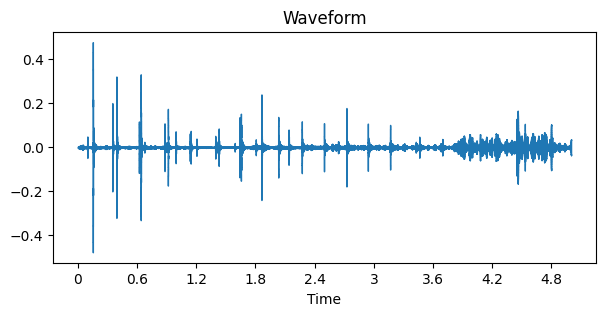

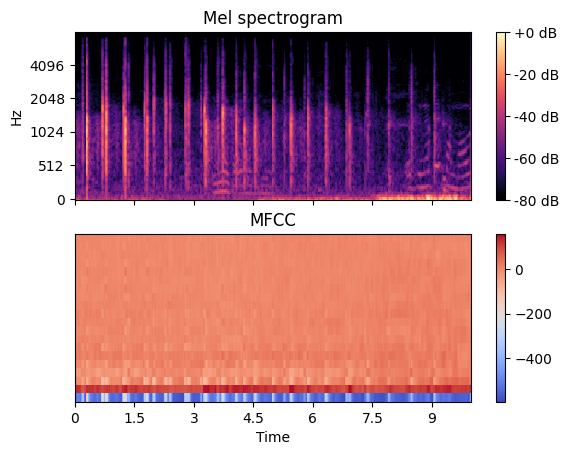

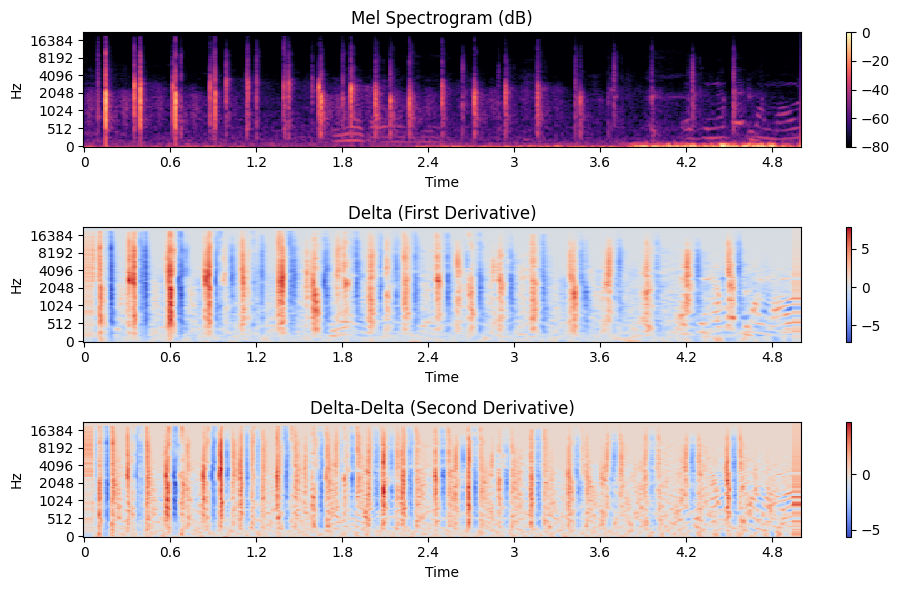

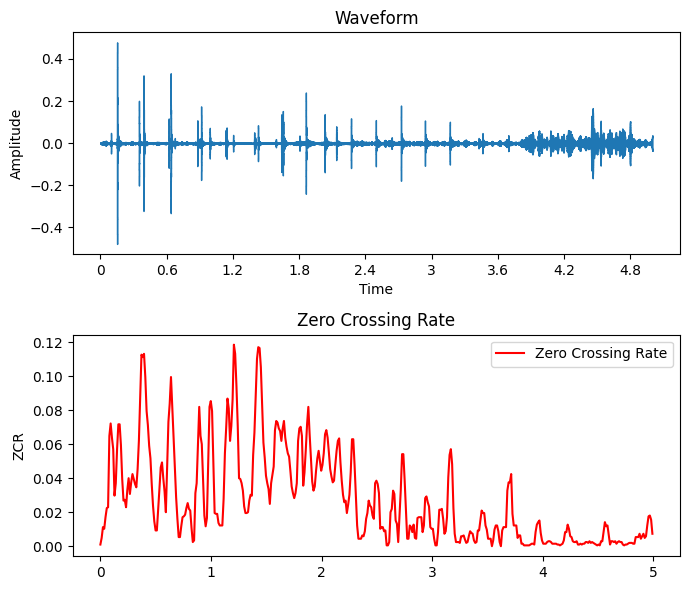

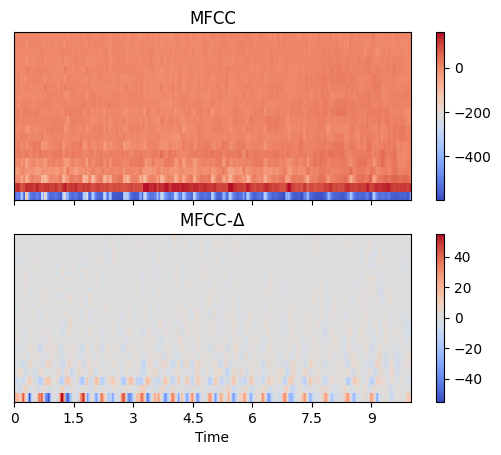


Array: [ 0.00088501  0.00088501  0.00085449 ... -0.03616333 -0.03631592
 -0.03634644]
Array Shape: (220500,)
Melspectrogram Shape: (128, 431)
MFCCs Shape: (20, 431)
ZCR Shape: (1, 431)
MFCCs Delta Shape: (20, 431)



In [12]:
show_random_clip(df=df_50)

### Categories and Folds

Dataset informations:
- The __ESC-50__ dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class);
- The __ESC-10__ subset contains 10 classes from the original 50;
- The original 50 classes can be loosely arranged into 5 __Macro-Categories__.

The dataset has been prearranged into 5 folds for comparable cross-validation, making sure that fragments from the same original source file are contained in a single fold.

Classes in all three dataset variants are equally distibuted across folds (every fold contain the same number of sample from a certain class). Also all classes in a certain dataset veriant presents the same number of samples.

In [13]:
#Uncomment to check the pivot tables

#category_fold_table = pd.crosstab(df_50['category'], df_50['fold'])
#category_fold_table = pd.crosstab(df_10['category'], df_10['fold'])
#category_fold_table = pd.crosstab(df_50['macro_category'], df_50['fold'])
#category_fold_table

### Plots Comparison

Visualizing samples from different classes.

In [14]:
def plot_waveforms(sample_df):

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    axes = axes.flatten()

    for i, (filename, category) in enumerate(zip(sample_df['filename'], sample_df['category'])):

        if os.path.exists(AUDIO_PATH + filename):
            y, sr = librosa.load(AUDIO_PATH + filename, sr=SAMPLING_RATE)
            ax = axes[i]
            librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.8)
            ax.set_title(category)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            axes[i].set_title(f"File Not Found: {filename}")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()


def plot_melspectrograms(sample_df):
    ig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    axes = axes.flatten()

    for i, (filename, category) in enumerate(zip(sample_df['filename'], sample_df['category'])):

        if os.path.exists(AUDIO_PATH + filename):
            array, sampling_rate = librosa.load(AUDIO_PATH + filename, sr=SAMPLING_RATE)
            ax = axes[i]

            melspectrogram = librosa.feature.melspectrogram(y=array, sr=sampling_rate)
            S_dB = librosa.power_to_db(melspectrogram, ref=np.max)
            librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000, ax=ax)

            ax.set_title(category)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            axes[i].set_title(f"File Not Found: {filename}")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()


def plot_mfccs(sample_df):
    ig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 6))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    axes = axes.flatten()

    for i, (filename, category) in enumerate(zip(sample_df['filename'], sample_df['category'])):

        if os.path.exists(AUDIO_PATH + filename):
            array, sampling_rate = librosa.load(AUDIO_PATH + filename, sr=SAMPLING_RATE)
            ax = axes[i]

            mfccs = librosa.feature.mfcc(y=array, sr=sampling_rate, n_mfcc=13)
            librosa.display.specshow(mfccs, x_axis='time', ax=ax)

            ax.set_title(category)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            axes[i].set_title(f"File Not Found: {filename}")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()


def plot_zcrs(sample_df):

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    axes = axes.flatten()

    for i, (filename, category) in enumerate(zip(sample_df['filename'], sample_df['category'])):

        if os.path.exists(AUDIO_PATH + filename):
            array, sampling_rate = librosa.load(AUDIO_PATH + filename, sr=SAMPLING_RATE)
            zcr = librosa.feature.zero_crossing_rate(array)

            frames = range(len(zcr[0]))
            t = librosa.frames_to_time(frames, sr=sampling_rate)

            ax = axes[i]
            ax.plot(t, zcr[0], color="r")
            ax.set_title(category)

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            axes[i].set_title(f"File Not Found: {filename}")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

#### ESC-10

In [15]:
sample_df = df_10.drop_duplicates(subset=['target'])
sample_df

filename  fold  target        category  esc10  src_file take  \
0     1-100032-A-0.wav     1       0             dog   True    100032    A   
24   1-116765-A-41.wav     1       9        chainsaw   True    116765    A   
54    1-17150-A-12.wav     1       4  crackling_fire   True     17150    A   
55   1-172649-A-40.wav     1       8      helicopter   True    172649    A   
62    1-17367-A-10.wav     1       2            rain   True     17367    A   
78   1-187207-A-20.wav     1       5     crying_baby   True    187207    A   
110   1-21934-A-38.wav     1       7      clock_tick   True     21934    A   
136   1-26143-A-21.wav     1       6        sneezing   True     26143    A   
141    1-26806-A-1.wav     1       1         rooster   True     26806    A   
148   1-28135-A-11.wav     1       3       sea_waves   True     28135    A   

     macro_category  
0                 0  
24                4  
54                1  
55                4  
62                1  
78                2  
110               3  
136               2  
141               0  
148               1

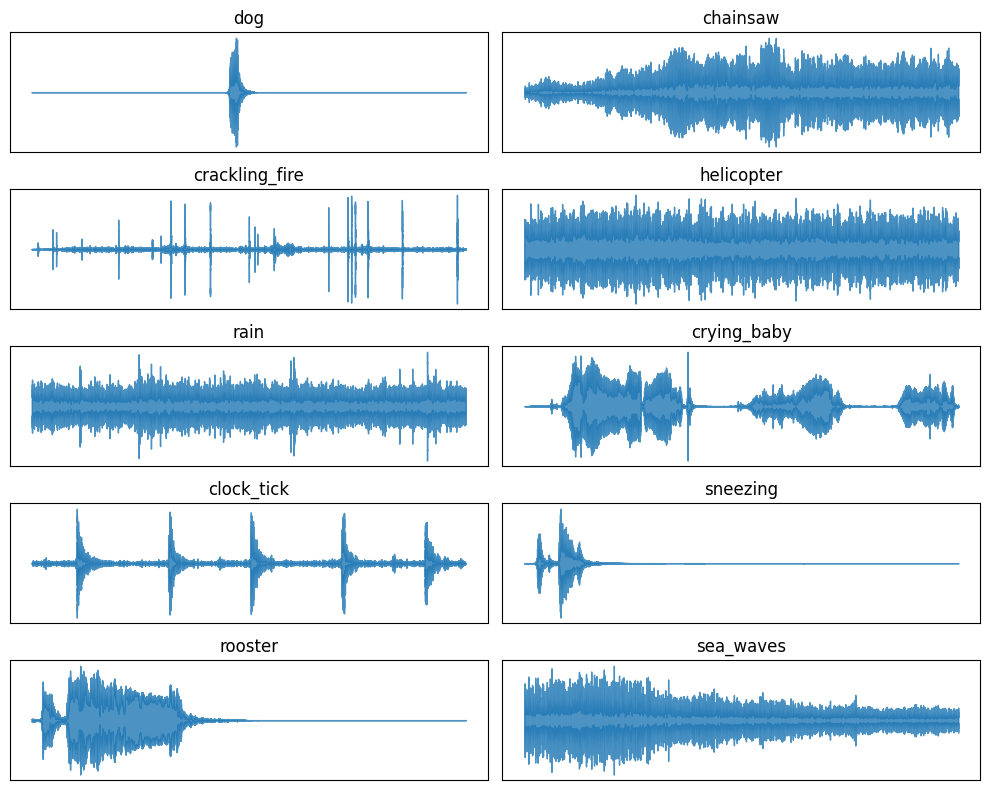

In [16]:
plot_waveforms(sample_df)

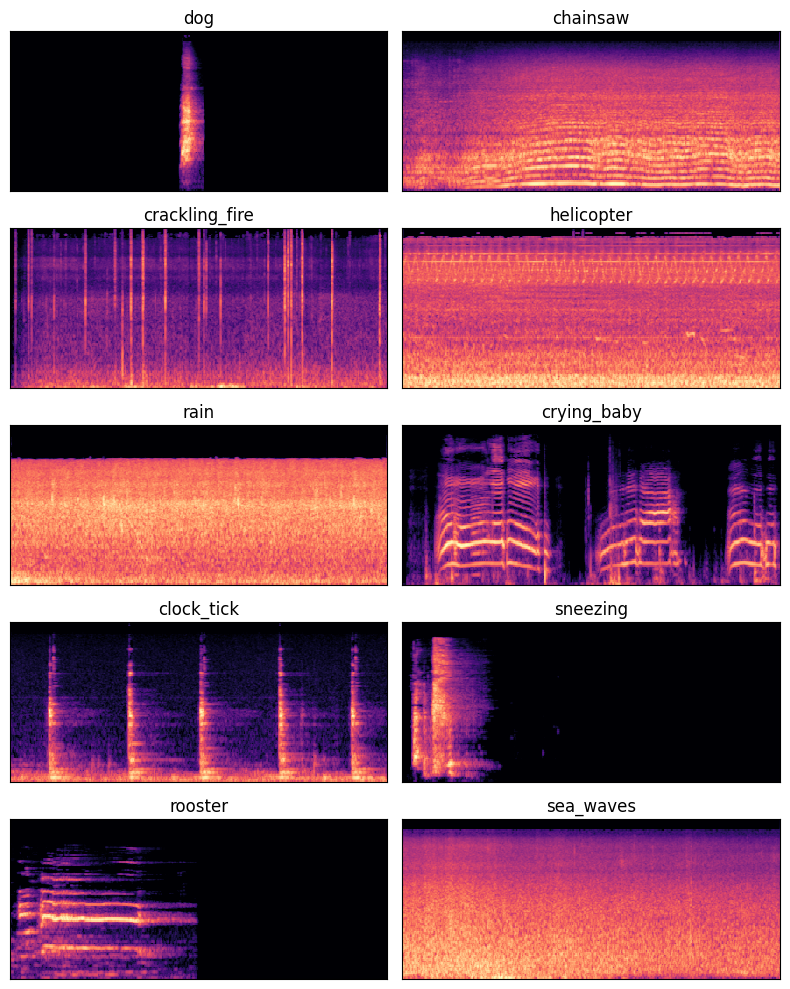

In [17]:
plot_melspectrograms(sample_df)

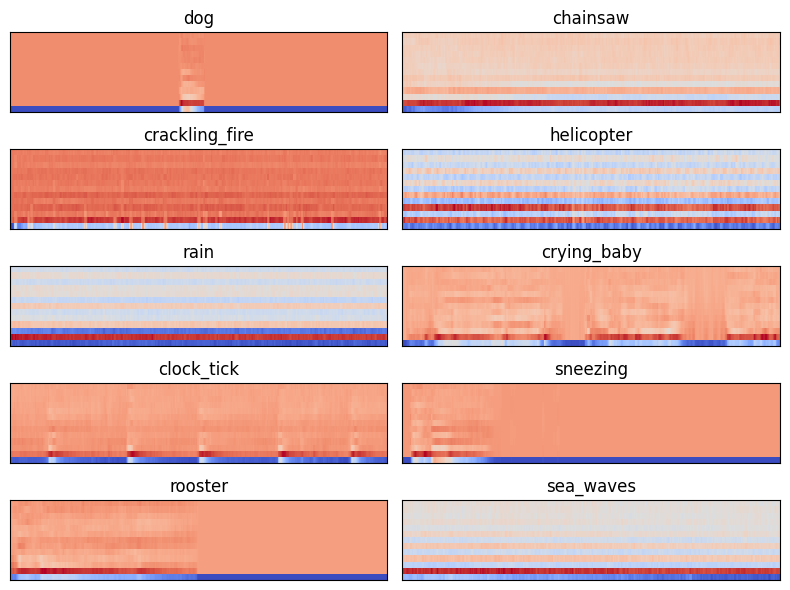

In [18]:
plot_mfccs(sample_df)

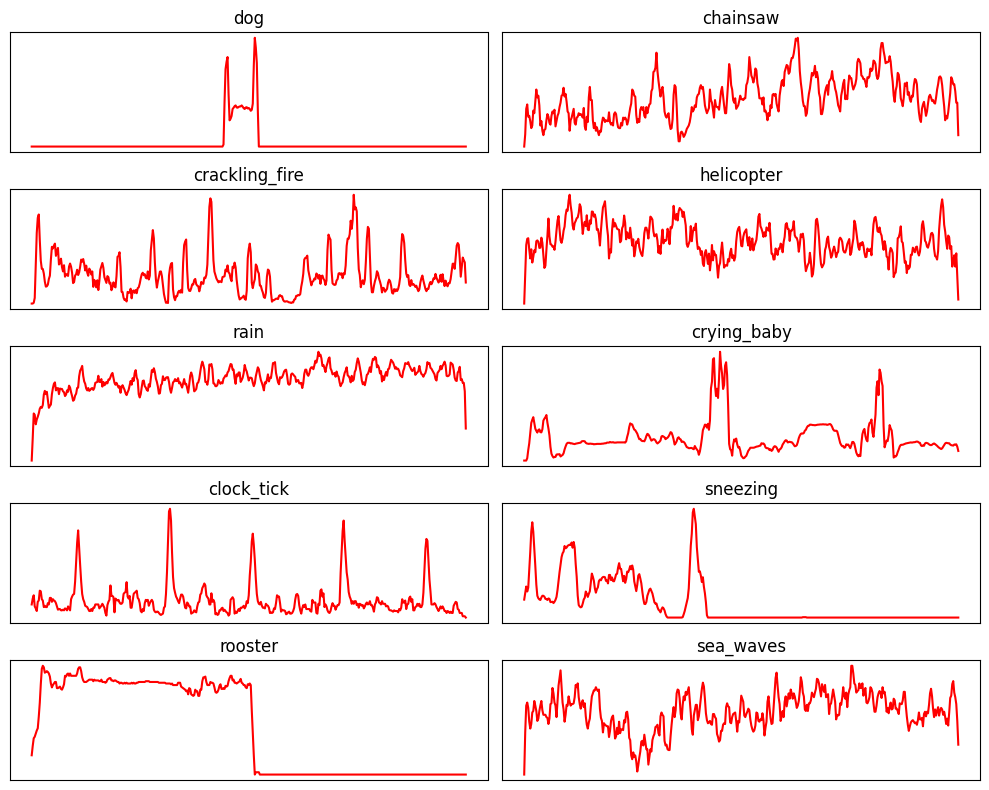

In [19]:
plot_zcrs(sample_df)

#### Macro-Categories

Since in theory Macro-Categories loosely contain classes coming from the same domain, we could expect a certain degree of similarity between those sub-classes.

By setting MACRO_CATEGORY with a value between 0-4, we can plot one sample from each sub-class in that Macro-Category.

Some classes presents some strong similarities. But from a quick look it seems that there is not much coherence inside Macro-Categories. Actually sometimes there are sub-classes with strong similarities between different Macro-Categories.

In [20]:
MACRO_CATEGORY = 4
macro_df = df_50[df_50['macro_category'] == MACRO_CATEGORY]
sample_df = macro_df.drop_duplicates(subset=['target'])
sample_df

filename  fold  target      category  esc10  src_file take  \
17   1-115545-A-48.wav     1      48     fireworks  False    115545    A   
24   1-116765-A-41.wav     1      41      chainsaw   True    116765    A   
25    1-11687-A-47.wav     1      47      airplane  False     11687    A   
28   1-119125-A-45.wav     1      45         train  False    119125    A   
33    1-13571-A-46.wav     1      46  church_bells  False     13571    A   
53    1-17124-A-43.wav     1      43      car_horn  False     17124    A   
55   1-172649-A-40.wav     1      40    helicopter   True    172649    A   
74    1-18527-A-44.wav     1      44        engine  False     18527    A   
82    1-18810-A-49.wav     1      49      hand_saw  False     18810    A   
165   1-31482-A-42.wav     1      42         siren  False     31482    A   

     macro_category  
17                4  
24                4  
25                4  
28                4  
33                4  
53                4  
55                4  
74                4  
82                4  
165               4

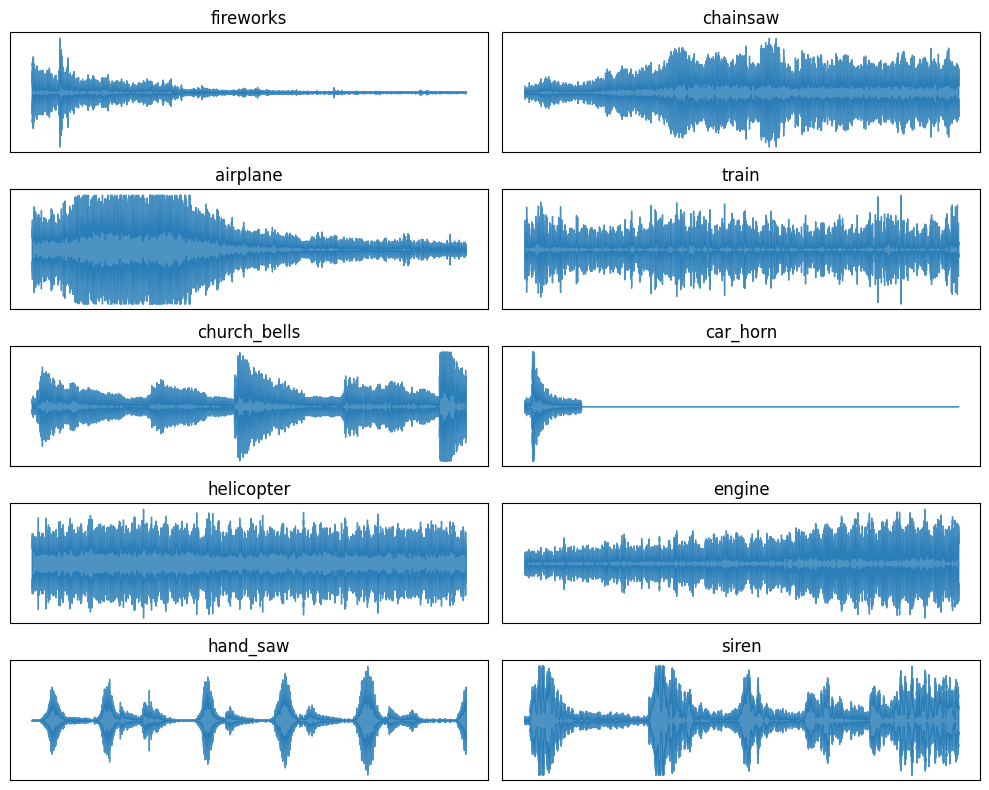

In [21]:
plot_waveforms(sample_df)

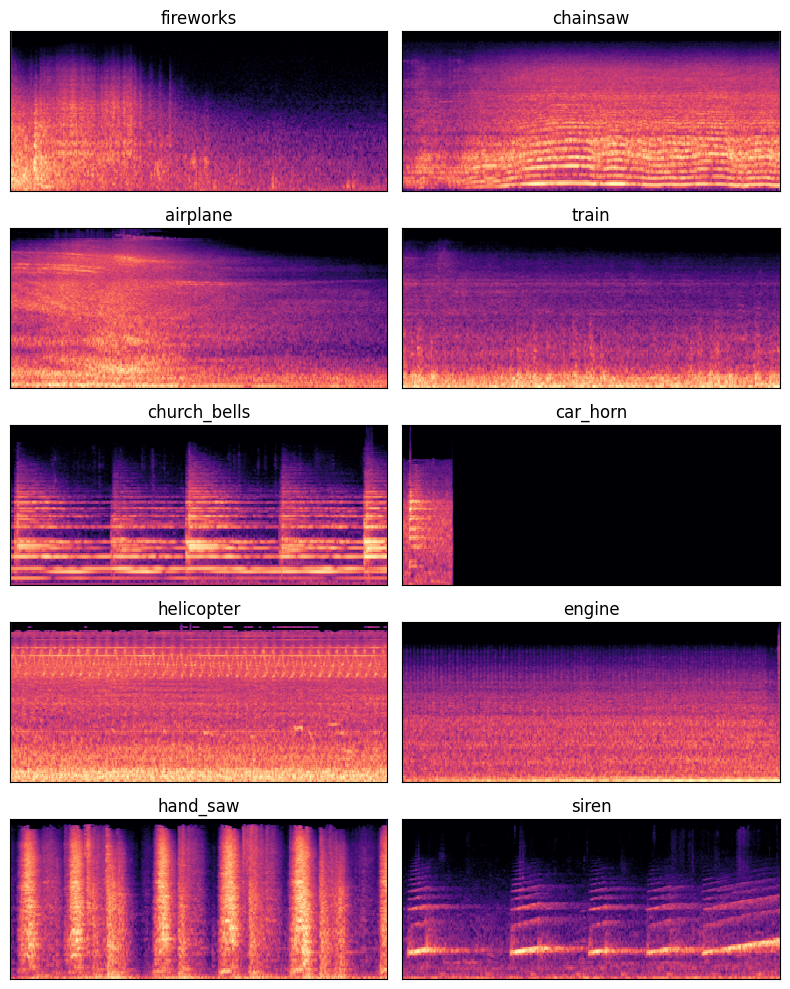

In [22]:
plot_melspectrograms(sample_df)

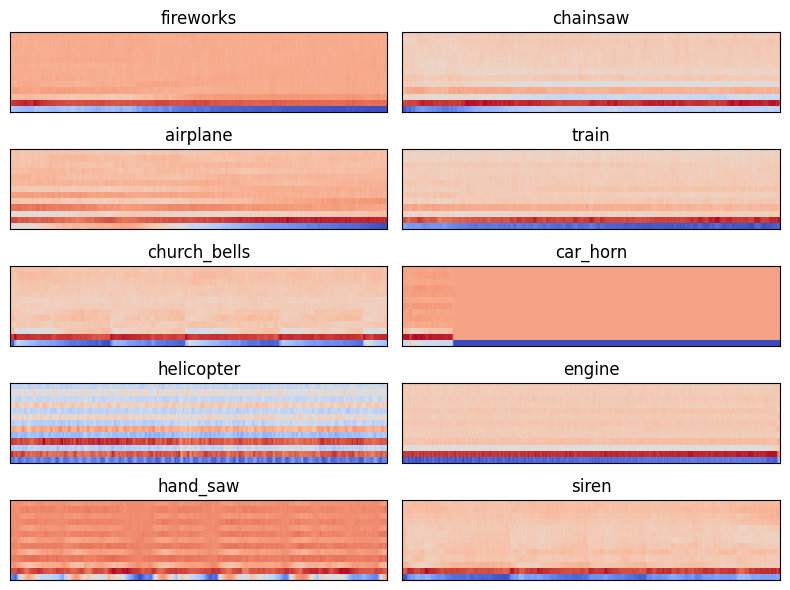

In [23]:
plot_mfccs(sample_df)

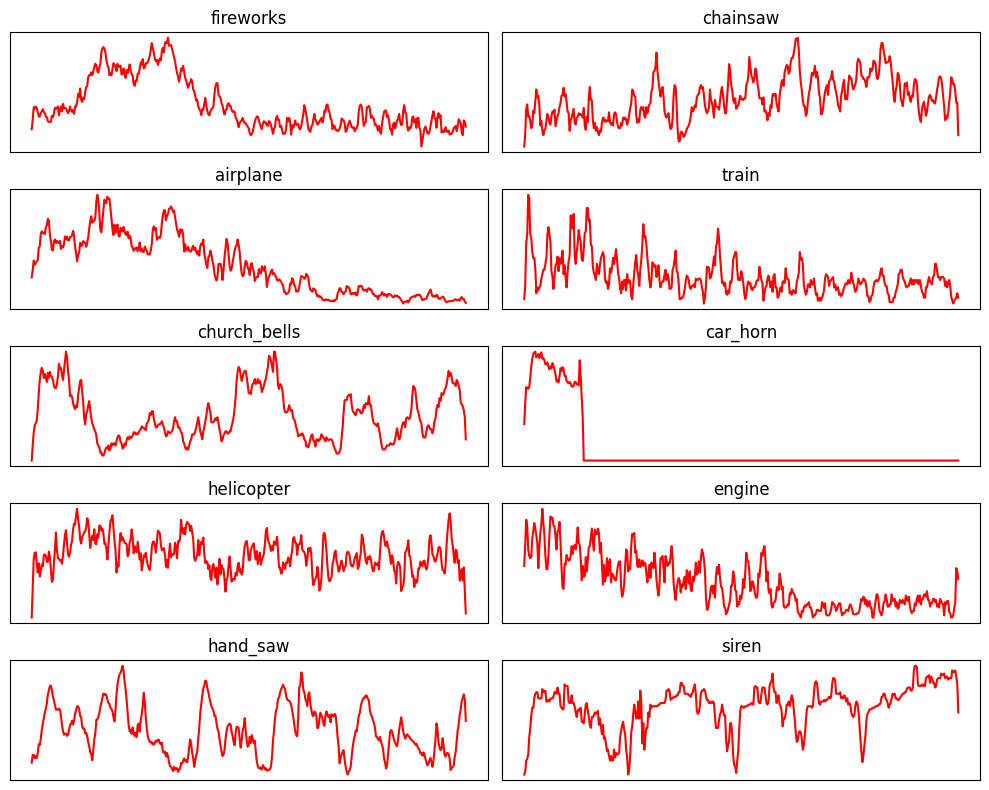

In [24]:
plot_zcrs(sample_df)

## Preprocessing

### Sampling Rate

For the modelling part of this notebook I will use the following sampling rate.

In [25]:
SAMPLING_RATE = 22050

### Train-Val-Test Split

The training set will be composed by the first 3 folds, while the validation set will be composed by the whole fold 4 and the test set will be composed by the whole fold 5.

In [26]:
df_50

filename  fold  target        category  esc10  src_file take  \
0      1-100032-A-0.wav     1       0             dog   True    100032    A   
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A   
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A   
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B   
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A   
...                 ...   ...     ...             ...    ...       ...  ...   
1995   5-263831-B-6.wav     5       6             hen  False    263831    B   
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A   
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A   
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A   
1999     5-9032-A-0.wav     5       0             dog   True      9032    A   

      macro_category  
0                  0  
1                  1  
2                  3  
3                  3  
4                  1  
...              ...  
1995               0  
1996               3  
1997               2  
1998               0  
1999               0  

[2000 rows x 8 columns]

In [27]:
def train_val_test_split(df_ext, val_fold=4, test_fold=5):

    df = df_ext.copy()

    df.loc[:, 'filename'] = AUDIO_PATH + df['filename']

    df_test = df[df['fold'] == test_fold]
    X_test = df_test['filename'].tolist()
    y_test = df_test['target'].tolist()

    df_val = df[df['fold'] == val_fold]
    X_val = df_val['filename'].tolist()
    y_val = df_val['target'].tolist()

    df_train = df[df['fold'] != test_fold]
    df_train = df_train[df_train['fold'] != val_fold]
    X_train = df_train['filename'].tolist()
    y_train = df_train['target'].tolist()

    return X_train, X_val, X_test, y_train, y_val, y_test

In [28]:
X_train_10, X_val_10, X_test_10, y_train_10, y_val_10, y_test_10 = train_val_test_split(df_10, val_fold=4, test_fold=5)

In [29]:
X_train_50, X_val_50, X_test_50, y_train_50, y_val_50, y_test_50 = train_val_test_split(df_50, val_fold=4, test_fold=5)

In [30]:
print(len(X_train_10))
print(len(X_val_10))
print(len(X_test_10))

240
80
80


In [31]:
print(len(X_train_50))
print(len(X_val_50))
print(len(X_test_50))

1200
400
400


### Augmentations

Here I tested some possible audio augmentations techniques.

In [62]:
def print_melspectrogram_comparison(original, augmented, sampling_rate=SAMPLING_RATE):

    fig, ax = plt.subplots(nrows=2, sharex=True)

    melspectrogram = librosa.feature.melspectrogram(y=original, sr=sampling_rate)
    S_dB = librosa.power_to_db(melspectrogram, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000, ax=ax[0])
    fig.colorbar(img, ax=[ax[0]], format='%+2.0f dB')
    ax[0].set(title='Original')
    ax[0].label_outer()

    melspectrogram = librosa.feature.melspectrogram(y=augmented, sr=sampling_rate)
    S_dB = librosa.power_to_db(melspectrogram, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000, ax=ax[1])
    fig.colorbar(img, ax=[ax[1]], format='%+2.0f dB')
    ax[1].set(title='Augmented')
    ax[1].label_outer()

    plt.show()

In [33]:
def load_random_audio(df=df_50):
    random_row = df.sample(n=1)
    filename = random_row['filename'].values[0]
    category = random_row['category'].values[0]
    path = AUDIO_PATH + filename
    audio, _ = librosa.load(path, sr=SAMPLING_RATE)
    return audio, category

In [64]:
audio, category = load_random_audio(df_50)
print(f'Original Audio: ({category})\n')
display(Audio(audio, rate=SAMPLING_RATE))

Original Audio: (coughing)



#### Time Stretching

Slowed Down and Cropped or Speeded Up and Padded

In [66]:
# Time stretching: speeds up (rate > 1) or slows down (rate < 1)
def time_stretch(audio, rate=1.0, noise_factor=0.002):
    """
    Adjusts an audio array to a fixed target length.

    If the audio is shorter than target_length, pads with Gaussian noise scaled by noise_factor.
    The padding is randomly applied either at the beginning or the end.
    If the audio is longer than target_length, randomly crops a segment of target_length.
    """

    original_length = len(audio)
    audio = librosa.effects.time_stretch(audio, rate=rate)
    stretched_length = len(audio)

    if original_length == stretched_length:
        return audio
    elif original_length < stretched_length:
        start_idx = np.random.randint(0, stretched_length - original_length + 1)
        return audio[start_idx:start_idx+original_length]
    else:
        pad_length = original_length - stretched_length
        pad = noise_factor * np.random.randn(pad_length)
        if np.random.rand() < 0.5:
            return np.concatenate([pad, audio])
        else:
            return np.concatenate([audio, pad])

Time-Stretched Audio: (slowed down and cropped)




Time-Stretched Audio: (speeded up and padded)



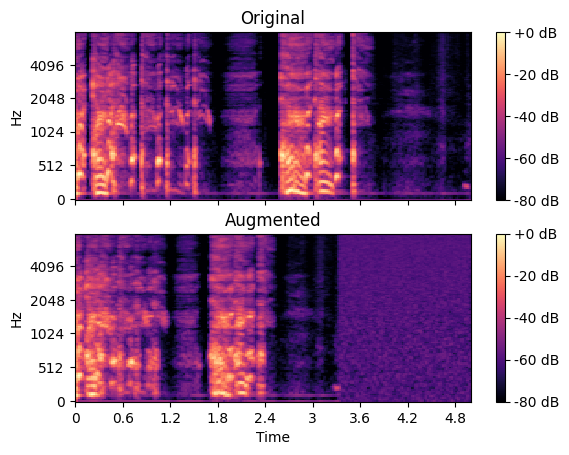

In [67]:
audio_time_stretched = time_stretch(audio, rate=0.5)
print('Time-Stretched Audio: (slowed down and cropped)\n')
display(Audio(audio_time_stretched, rate=SAMPLING_RATE))
print()
audio_time_stretched = time_stretch(audio, rate=1.5)
print('Time-Stretched Audio: (speeded up and padded)\n')
display(Audio(audio_time_stretched, rate=SAMPLING_RATE))
print()

print_melspectrogram_comparison(original=audio, augmented=audio_time_stretched)

#### Pitch Shift

Pitch-Shifted Audio:



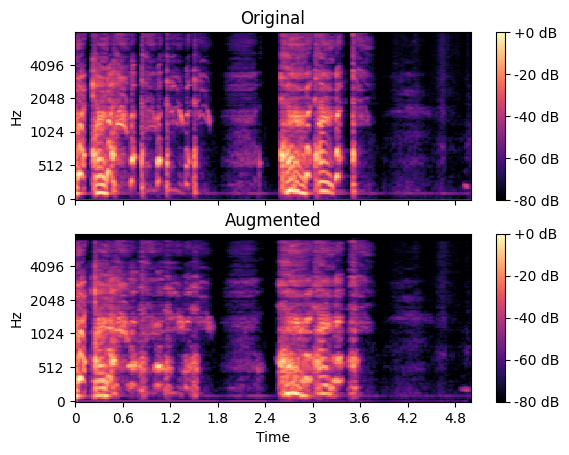

In [68]:
# Pitch shifting: n_steps > 0 shifts up; n_steps < 0 shifts down
def pitch_shift(audio, n_steps):
    return librosa.effects.pitch_shift(audio, sr=SAMPLING_RATE, n_steps=n_steps)


audio_shifted = pitch_shift(audio, n_steps=-2)
print('Pitch-Shifted Audio:\n')
display(Audio(audio_shifted, rate=SAMPLING_RATE))
print()


print_melspectrogram_comparison(original=audio, augmented=audio_shifted)

#### Gaussian Noise

Audio with Noise:



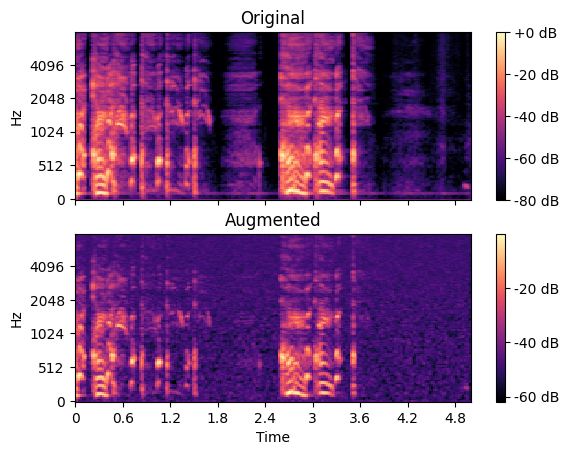

In [69]:
# Adding Gaussian noise to the audio signal
def add_noise(audio, sigma=0.002):
    noise = np.random.normal(loc=0., scale=sigma, size=audio.shape).astype('float32')
    return audio + noise


audio_noisy = add_noise(audio, sigma=0.01)
print("Audio with Noise:\n")
display(Audio(audio_noisy, rate=SAMPLING_RATE))
print()

print_melspectrogram_comparison(original=audio, augmented=audio_noisy)

#### Shifting

Time-Shifted Audio:



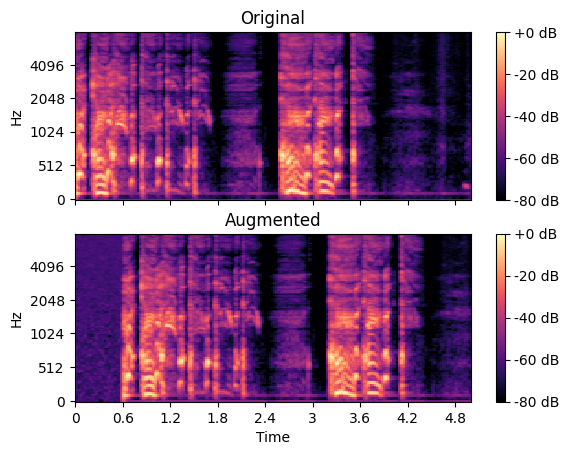

In [71]:
def shift_audio(audio, shift_max=0.2, noise_factor=0.0001):
    """
    Shifts the audio in time by a random amount, up to a fraction (shift_max) of the audio's length.
    Fills the empty region with Gaussian noise scaled by noise_factor.
    """

    max_shift = int(len(audio) * shift_max)
    shift = np.random.randint(0, max_shift)

    # Randomly decide the direction of the shift
    if np.random.rand() < 0.5:
        shift = -shift

    shifted_audio = np.roll(audio, shift)

    if shift > 0:
        shifted_audio[:shift] = noise_factor * np.random.randn(shift)
    elif shift < 0:
        shifted_audio[shift:] = noise_factor * np.random.randn(-shift)

    return shifted_audio


audio_shifted = shift_audio(audio, shift_max=0.4, noise_factor=0.002)
print("Time-Shifted Audio:\n")
display(Audio(audio_shifted, rate=SAMPLING_RATE))
print()

print_melspectrogram_comparison(original=audio, augmented=audio_shifted)

#### Combination

Pitch Shifting with n_steps 0.06130683319031638
Gaussian Noise applied



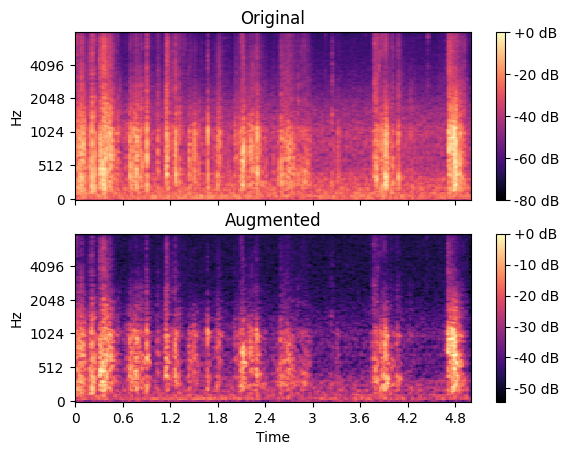

In [63]:
# Combined random augmentation pipeline
def random_augmentation(audio, sr=SAMPLING_RATE):

    audio_len = len(audio)
    stretched = False

    # Randomly apply time stretching
    if np.random.rand() < 0.5:
        rate = np.random.uniform(0.75, 1.25)
        print(f'Time Stretching with rate {rate}')
        audio = time_stretch(audio, rate=rate, noise_factor=0.002)
        stretched = True

    # Randomly apply pitch shifting
    if np.random.rand() < 0.5:
        n_steps = np.random.uniform(-2, 2)
        print(f'Pitch Shifting with n_steps {n_steps}')
        audio = pitch_shift(audio, n_steps)

    # Randomly add noise
    if np.random.rand() < 0.5:
        print('Gaussian Noise applied')
        audio = add_noise(audio, sigma=0.001)

    # Randomly shift audio in time
    if not stretched and np.random.rand() < 0.5:
        print('Shifting applied')
        audio = shift_audio(audio, shift_max=0.2, noise_factor=0.002)

    return audio



audio_random_aug = random_augmentation(audio)
print()
display(Audio(audio_random_aug, rate=SAMPLING_RATE))
print()

print_melspectrogram_comparison(original=audio, augmented=audio_random_aug)

### Create Dataset

In this section have been defined the pipeline responible for the datasets cration.

In [59]:
FEATURES_SHAPE=(60, 216, 2)

In [60]:
def load_audio_file(file_path):
    audio, _ = librosa.load(file_path, sr=SAMPLING_RATE)
    return audio



def tf_min_max_normalize(features):
    # features shape: (height, width, channels)
    min_vals = tf.reduce_min(features, axis=[0, 1], keepdims=True)
    max_vals = tf.reduce_max(features, axis=[0, 1], keepdims=True)
    epsilon = 1e-8
    normalized_features = (features - min_vals) / (max_vals - min_vals + epsilon)
    return normalized_features



def data_augmentation(audio,
                      gaussian_noise_sigma=0.02,
                      pitch_shifting_n_steps=4,
                      time_stretching_rate_range=(0.5,1.5),
                      padding_noise_factor=0.005,
                      shift_max=0.4,
                      verbose=False):

    audio_length = len(audio)
    stretched = False

    # Gaussian noise
    if np.random.rand() < 0.6:
        if verbose: print('Gaussian Noise applied')
        audio = add_noise(audio, sigma=gaussian_noise_sigma)

    # Pitch shifting
    if np.random.rand() < 0.6:
        n_steps = np.random.uniform(-pitch_shifting_n_steps, pitch_shifting_n_steps)
        if verbose: print(f'Pitch Shifting with n_steps {n_steps}')
        audio = pitch_shift(audio, n_steps)

    # Time stretching
    if np.random.rand() < 0.6:
        min, max = time_stretching_rate_range
        rate = np.random.uniform(min, max)
        if verbose: print(f'Time Stretching with rate {rate}')
        audio = time_stretch(audio, rate=rate, noise_factor=padding_noise_factor)
        stretched = True

    # Shift audio in time
    if not stretched and np.random.rand() < 0.6:
        if verbose: print('Shifting applied')
        audio = shift_audio(audio, shift_max=shift_max, noise_factor=padding_noise_factor)

    return audio.astype(np.float32)



def compute_spectrogram(audio, n_mels=60, compute_deltas=True):

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLING_RATE, n_mels=n_mels, win_length=1024, hop_length=512)
    mel_spec_db = librosa.power_to_db(S=mel_spec, ref=np.max)

    if not compute_deltas:
        return mel_spec_db.astype(np.float32)
    else:
        mel_spec_delta = librosa.feature.delta(data=mel_spec_db)
        features = np.stack([mel_spec_db, mel_spec_delta], axis=-1)
        return features.astype(np.float32)



def set_spectrogram_shape(features, label):
    features.set_shape(FEATURES_SHAPE)
    return features, label



def create_dataset(file_names, labels, cache_file=None, shuffle=True, repeat=True,
                   augmentation=True, batch_size=20, num_parallel_calls=tf.data.AUTOTUNE):

    """
    Creates a TensorFlow Dataset pipeline for audio data.

    The pipeline includes:
      - Creating the dataset from file names and labels.
      - Mapping a custom function to load the raw audio samples.
      - Caching the dataset to avoid redundant computation.
      - Shuffling the data.
      - Repeating the dataset indefinitely.
      - Apply random audio augmentations.
      - Computing mel-spectrogra and deltas and stacking them.
      - Normalizing the spectrogram + deltas.
      - Batching the data.
      - Prefetching batches to improve performance.
    """

    # 1. Create a Dataset object from file names and labels
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))

    # 2. Load Raw Audio: map the load_audio_file function to the file_names
    dataset = dataset.map(
        lambda file_name, label: (
            tf.numpy_function(load_audio_file, [file_name], tf.float32),
            label
        ),
        num_parallel_calls=num_parallel_calls
    )

    # 3. Cache the dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # 4. Shuffle the dataset
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_names))

    # 5. Repeat the dataset indefinitely to prevent running out of samples during training.
    if repeat:
        dataset = dataset.repeat()


    # 6. Random Data Augmentation
    if augmentation:
        dataset = dataset.map(
            lambda audio, label: (
                tf.numpy_function(data_augmentation, [audio], tf.float32),
                label
            ),
            num_parallel_calls=num_parallel_calls
        )

    # 7. Compute Mel-Spectrogram and Deltas
    dataset = dataset.map(
        lambda raw_audio, label: (
            tf.numpy_function(compute_spectrogram, [raw_audio], tf.float32),
            label
        ),
        num_parallel_calls=num_parallel_calls
    )

    # 8. Normalize
    dataset = dataset.map(
        lambda features, label: (
            tf.numpy_function(tf_min_max_normalize, [features], tf.float32),
            label
        ),
        num_parallel_calls=num_parallel_calls
    )

    # 9. Setting Shape
    dataset = dataset.map(set_spectrogram_shape, num_parallel_calls=tf.data.AUTOTUNE)

    # 10. Batch the data so that each training step processes a fixed number of samples.
    dataset = dataset.batch(batch_size)

    # 11. Prefetch to overlap the data preprocessing and model training.
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

#### ESC-10

In [43]:
batch_size = 80

train_dataset = create_dataset(X_train_10, y_train_10,
                               cache_file='train_cache',
                               shuffle=True,
                               augmentation=True,
                               batch_size=batch_size)

val_dataset = create_dataset(X_val_10, y_val_10,
                              cache_file='val_cache',
                              shuffle=False,
                              augmentation=False,
                              batch_size=batch_size)

test_dataset = create_dataset(X_test_10, y_test_10,
                              cache_file='test_cache',
                              shuffle=False,
                              augmentation=False,
                              batch_size=batch_size)

train_steps = int(np.ceil(len(X_train_10) / batch_size))
val_steps = int(np.ceil(len(X_val_10) / batch_size))
test_steps = int(np.ceil(len(X_test_10) / batch_size))

In [44]:
for data_batch, labels_batch in train_dataset:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    print()
    print('Data Sample:\n', data_batch[1])
    print('\nSample Label:\n', labels_batch[0])
    break

Data batch shape: (80, 60, 216, 2)
Labels batch shape: (80,)

Data Sample:
 tf.Tensor(
[[[0.13637488 0.48558956]
  [0.17568107 0.48558956]
  [0.14321715 0.48558956]
  ...
  [0.25437018 0.31887907]
  [0.19444707 0.31887907]
  [0.131585   0.31887907]]

 [[0.08215167 0.47678915]
  [0.14153996 0.47678915]
  [0.2092569  0.47678915]
  ...
  [0.16065153 0.3042748 ]
  [0.11419365 0.3042748 ]
  [0.23208974 0.3042748 ]]

 [[0.15768671 0.4539289 ]
  [0.1656591  0.4539289 ]
  [0.11370776 0.4539289 ]
  ...
  [0.24488392 0.3709341 ]
  [0.2606641  0.3709341 ]
  [0.24322845 0.3709341 ]]

 ...

 [[0.15512279 0.46628138]
  [0.17922108 0.46628138]
  [0.19394222 0.46628138]
  ...
  [0.24352375 0.30396336]
  [0.253981   0.30396336]
  [0.19148749 0.30396336]]

 [[0.14120783 0.47657704]
  [0.16905817 0.47657704]
  [0.20234759 0.47657704]
  ...
  [0.26691037 0.30506366]
  [0.284465   0.30506366]
  [0.22135651 0.30506366]]

 [[0.09611114 0.48098966]
  [0.17603311 0.48098966]
  [0.1665338  0.48098966]
  ...
  [

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 60, 216, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# 2. Modelling

CNNs implementations.

In [ ]:
# Choose dataset (ESC-10 / ESC-50)
CPKT = 'cpkt/ESC-10/'
NUM_CLASSES = 10
labels = [df_10_dict[i] for i in range(len(df_10_dict))]

#CPKT = 'cpkt/ESC-50/'
#NUM_CLASSES = 50
#labels = [df_50_dict[i] for i in range(len(df_50_dict))]

In [ ]:
%mkdir "cpkt"
%mkdir "cpkt/ESC-10"
%mkdir "cpkt/ESC-50"

In [ ]:
def plot_loss(history, model_name, path=''):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['loss'], label='loss')
    plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.savefig(path + model_name + '_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_accuracy(history, model_name, path=''):
    plt.figure(figsize=(10,6))
    plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
    plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.savefig(path + model_name + '_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, labels, model_name, path=''):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix: ' + model_name)
    plt.savefig(path + model_name + '_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

## Baseline

Simple CNN architecture used as a Baseline.

In [ ]:
MODEL_NAME = 'baseline'
MODEL_DIR = 'cpkt/ESC-10/baseline_a2/'

%mkdir 'cpkt/ESC-10/baseline_a2/'

In [ ]:
def BasicConvNet(num_classes=10):

    inputs = tf.keras.Input(shape=FEATURES_SHAPE)
    x = layers.Conv2D(filters=32, kernel_size=6, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=5, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=4, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
baseline = BasicConvNet(num_classes = NUM_CLASSES)
baseline.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60, 216, 2)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 55, 211, 32)         │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 105, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 23, 101, 64)         │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 47, 128)          │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 23, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 21, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 10, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │         512,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,013,278 (3.87 MB)

 Trainable params: 1,013,278 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback_mc = tf.keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_best_model.keras',
                                                 save_best_only=True,
                                                 monitor="val_loss")

callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


start_time = time.time()

baseline_history = baseline.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[callback_mc, callback_es],
    verbose=2
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds")

#model.save("final_model.keras")

Epoch 1/100
3/3 - 33s - 11s/step - accuracy: 0.1125 - loss: 2.3078 - val_accuracy: 0.2250 - val_loss: 2.2843
Epoch 2/100
3/3 - 22s - 7s/step - accuracy: 0.1333 - loss: 2.2821 - val_accuracy: 0.1500 - val_loss: 2.2284
Epoch 3/100
3/3 - 25s - 8s/step - accuracy: 0.1292 - loss: 2.2841 - val_accuracy: 0.2250 - val_loss: 2.1558
Epoch 4/100
3/3 - 25s - 8s/step - accuracy: 0.1542 - loss: 2.2387 - val_accuracy: 0.2625 - val_loss: 2.0724
Epoch 5/100
3/3 - 25s - 8s/step - accuracy: 0.1542 - loss: 2.1887 - val_accuracy: 0.3125 - val_loss: 1.9922
Epoch 6/100
3/3 - 25s - 8s/step - accuracy: 0.1792 - loss: 2.1151 - val_accuracy: 0.2875 - val_loss: 2.0540
Epoch 7/100
3/3 - 27s - 9s/step - accuracy: 0.1333 - loss: 2.2313 - val_accuracy: 0.3375 - val_loss: 1.9681
Epoch 8/100
3/3 - 24s - 8s/step - accuracy: 0.1625 - loss: 2.1234 - val_accuracy: 0.1875 - val_loss: 1.9432
Epoch 9/100
3/3 - 24s - 8s/step - accuracy: 0.1333 - loss: 2.2245 - val_accuracy: 0.2750 - val_loss: 1.9248
Epoch 10/100
3/3 - 22s - 7s

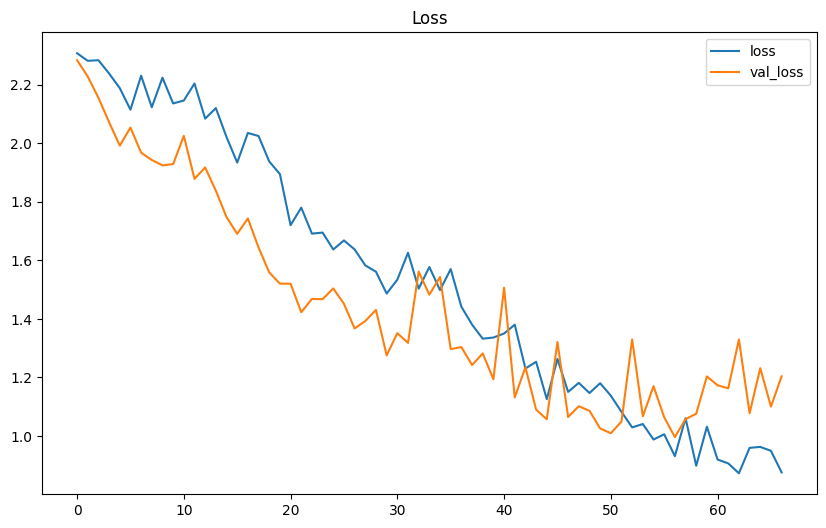

In [ ]:
plot_loss(baseline_history, MODEL_NAME, MODEL_DIR)

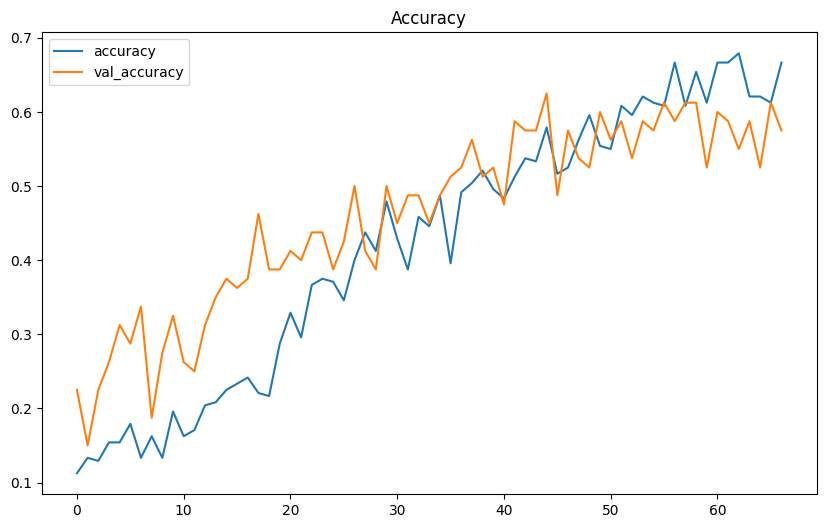

In [ ]:
plot_accuracy(baseline_history, MODEL_NAME, MODEL_DIR)

In [ ]:
best_baseline = tf.keras.models.load_model(MODEL_DIR + MODEL_NAME + '_best_model.keras')

loss, acc = best_baseline.evaluate(test_dataset, steps=test_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7000 - loss: 0.9903


In [ ]:
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {acc}')

Test Loss: 0.9902521967887878
Test Accuracy: 0.699999988079071


In [ ]:
predictions = best_baseline.predict(test_dataset, steps=test_steps, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y.numpy() for x, y in test_dataset.take(test_steps)], axis=0)
cm = confusion_matrix(y_true, y_pred)

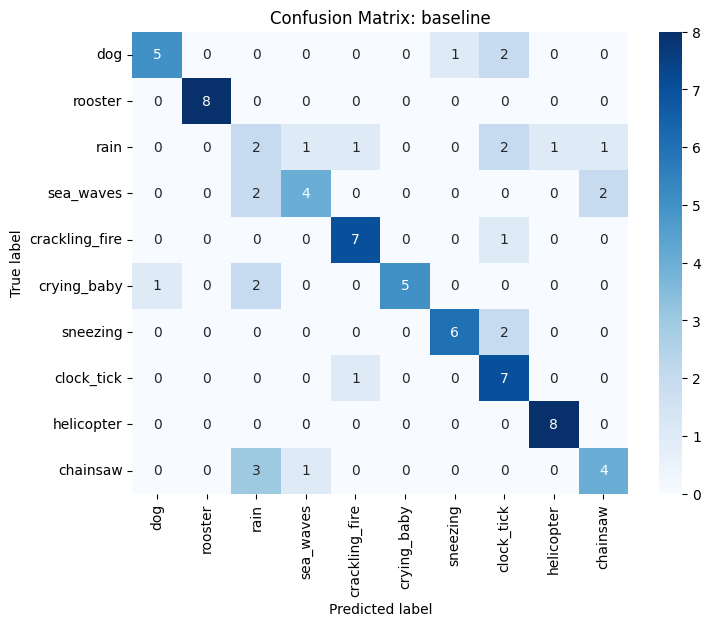

In [ ]:
plot_confusion_matrix(cm, labels, MODEL_NAME, MODEL_DIR)

## MelNet

Inspired to the MelNet architecture proposed in:

"_An Ensemble Stacked Convolutional Neural Network Model for Environmental Event Sound Recognition_".

In [ ]:
MODEL_NAME = 'melnet'
MODEL_DIR = 'cpkt/ESC-10/melnet_a2_regularized/'

%mkdir 'cpkt/ESC-10/melnet_a2_regularized'

In [ ]:
def MelNet(num_classes=10):

    inputs = tf.keras.Input(shape=FEATURES_SHAPE)

    x = layers.Conv2D(filters=24, kernel_size=6, strides=1, padding='same', activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)  # ADDED TO REDUCE OVERFITTING
    x = layers.Conv2D(filters=24, kernel_size=6, strides=1, padding='same', activation='relu')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=48, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = layers.Dropout(0.2)(x)  # ADDED TO REDUCE OVERFITTING
    x = layers.Conv2D(filters=48, kernel_size=5, strides=2, padding='same', activation='relu')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=64, kernel_size=4, strides=2, padding='same', activation='relu')(x)

    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)  # ADDED TO REDUCE OVERFITTING
    x = layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)  # ADDED TO REDUCE OVERFITTING
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
mel_net = MelNet(num_classes = NUM_CLASSES)
mel_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60, 216, 2)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 60, 216, 24)         │           1,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 216, 24)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 216, 24)         │          20,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 108, 24)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 54, 48)          │          28,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 54, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 27, 48)           │          57,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 13, 48)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 7, 64)            │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 200)                 │         179,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           2,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 339,890 (1.30 MB)

 Trainable params: 339,762 (1.30 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
callback_mc = tf.keras.callbacks.ModelCheckpoint(MODEL_DIR + MODEL_NAME + '_best_model.keras',
                                                 save_best_only=True,
                                                 monitor="val_loss")

callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


start_time = time.time()

melnet_history = mel_net.fit(train_dataset,
                             epochs=100,
                             steps_per_epoch=train_steps,
                             validation_data=val_dataset,
                             validation_steps=val_steps,
                             callbacks=[callback_mc, callback_es],
                             verbose=2
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds")

#model.save("final_model.keras")

Epoch 1/100
3/3 - 34s - 11s/step - accuracy: 0.1042 - loss: 5.8255 - val_accuracy: 0.1000 - val_loss: 5.4367
Epoch 2/100
3/3 - 22s - 7s/step - accuracy: 0.1375 - loss: 5.3906 - val_accuracy: 0.1750 - val_loss: 5.2810
Epoch 3/100
3/3 - 25s - 8s/step - accuracy: 0.1375 - loss: 5.1978 - val_accuracy: 0.1000 - val_loss: 5.1165
Epoch 4/100
3/3 - 25s - 8s/step - accuracy: 0.1333 - loss: 5.0247 - val_accuracy: 0.1500 - val_loss: 4.9495
Epoch 5/100
3/3 - 25s - 8s/step - accuracy: 0.1500 - loss: 4.8824 - val_accuracy: 0.1625 - val_loss: 4.7992
Epoch 6/100
3/3 - 26s - 9s/step - accuracy: 0.1750 - loss: 4.6769 - val_accuracy: 0.1875 - val_loss: 4.6505
Epoch 7/100
3/3 - 25s - 8s/step - accuracy: 0.1917 - loss: 4.4448 - val_accuracy: 0.1750 - val_loss: 4.5024
Epoch 8/100
3/3 - 24s - 8s/step - accuracy: 0.1833 - loss: 4.2388 - val_accuracy: 0.2000 - val_loss: 4.3653
Epoch 9/100
3/3 - 26s - 9s/step - accuracy: 0.2833 - loss: 4.0536 - val_accuracy: 0.2125 - val_loss: 4.2457
Epoch 10/100
3/3 - 25s - 8s

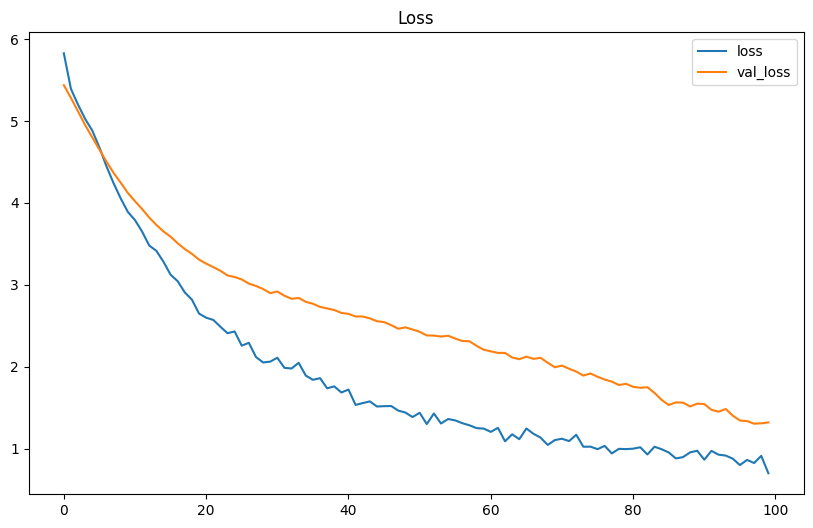

In [ ]:
plot_loss(melnet_history, MODEL_NAME, MODEL_DIR)

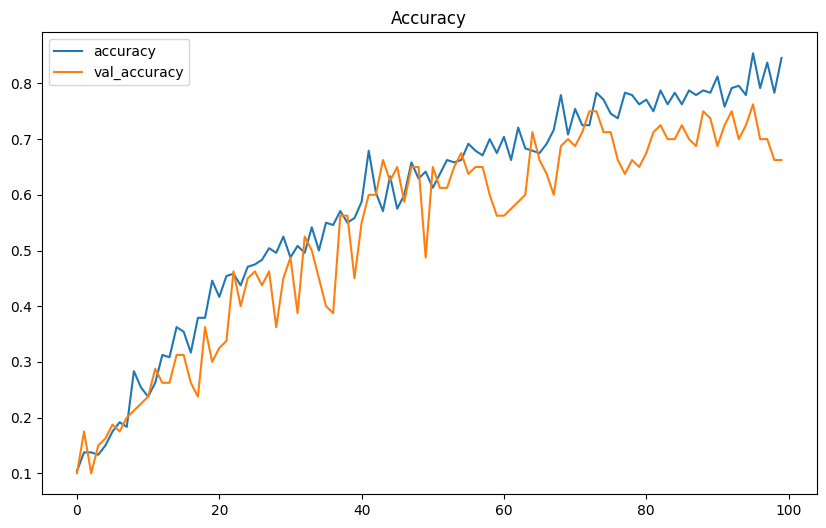

In [ ]:
plot_accuracy(melnet_history, MODEL_NAME, MODEL_DIR)

In [ ]:
best_melnet = tf.keras.models.load_model(MODEL_DIR + MODEL_NAME + '_best_model.keras')

loss, acc = best_melnet.evaluate(test_dataset, steps=test_steps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6750 - loss: 1.3709


In [ ]:
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {acc}')

Test Loss: 1.3708913326263428
Test Accuracy: 0.675000011920929


In [ ]:
predictions = best_melnet.predict(test_dataset, steps=test_steps, verbose=0)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y.numpy() for x, y in test_dataset.take(test_steps)], axis=0)
cm = confusion_matrix(y_true, y_pred)

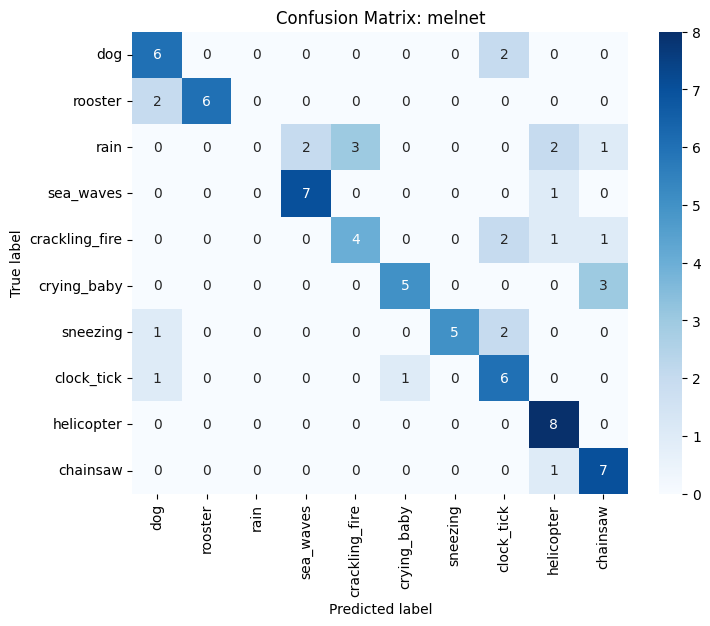

In [ ]:
plot_confusion_matrix(cm, labels, MODEL_NAME, MODEL_DIR)